# Линейный классификатор методом опорных векторов

Реализация по классической схеме с обновлением весов через градиентный спуск

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs, make_circles, make_moons

In [2]:
class LinearSVC:
    EPS = 0.01
    
    def __init__(self, C=0.1):
        self.C = C
        self.w = None
        

    def fit(self, X, y, lr=0.01, max_iter=200):
        if not (np.abs(y) == 1).all():
            y_train = y * 2 - 1
        else:
            y_train = y
        n, m = X.shape
        # include bias
        X_train = np.hstack([X, np.ones((n,1))])
        if self.w is None:
            # include bias
            self.w = np.random.randn(m+1)
        self.loss = []
        for e in range(max_iter):
            train_loss = 0
            for i in range(n):
                margin = y_train[i] * np.dot(self.w, X_train[i])
                if margin >= 1:
                    self.w -= lr * self.C * self.w / max_iter
                else:
                    self.w -= lr * (self.C * self.w / max_iter - y_train[i] * X_train[i])
                train_loss += self.margin_loss(X_train[i], y_train[i])
            self.loss.append(train_loss)
            if e > 3 and abs(self.loss[-1] - self.loss[-2]) < self.EPS:
                print('iter stoped on', e)
                break


    def predict(self, X):
        return np.sign(self.decision_function(X))
    
    
    def decision_function(self, X):
        n, m = X.shape
        X_train = np.hstack([X, np.ones((n,1))])
        res = []
        for i in range(n):
            res.append(np.dot(self.w, X_train[i]))
        return np.array(res)

    
    def margin_loss(self, x, y):
        return self.hinge_loss(x, y) + self.C * np.dot(self.w, self.w) / 2


    def hinge_loss(self, x, y):
        return max(0.0, 1 - y * np.dot(self.w, x))

In [3]:
def plot_class_border(X, y, svm):
    plt.figure(figsize=(15,8))
    eps = 0.5
    xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 500),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 500))


    rgb = np.array([[210, 0, 0], [0, 0, 150]])/255.0

    z_model = svm.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plt.contour(xx, yy, z_model, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    plt.contourf(xx, yy, np.sign(z_model.reshape(xx.shape)), alpha=0.3, levels=2, 
                 cmap=ListedColormap(rgb), zorder=1)

    plt.show()

In [4]:
def plot_classification_set(X, y):
    plt.figure(figsize=(15,10))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
    plt.show()

## Кейс 1: Линейно разделимые непересекающиеся классы

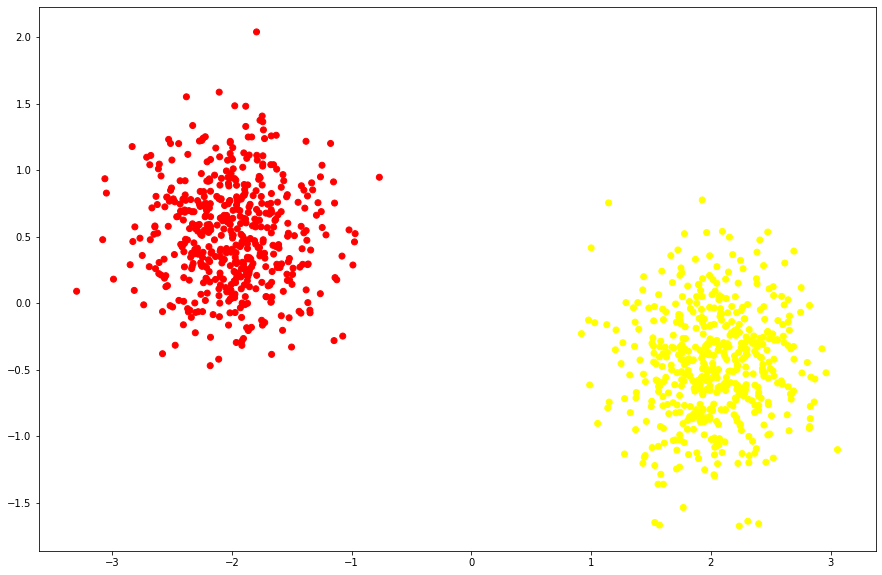

In [5]:
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[2,-0.5]], cluster_std=0.4, random_state=42)
plot_classification_set(X, y)

In [6]:
%%time
svm = LinearSVC()
svm.fit(X, y)

CPU times: user 6.01 s, sys: 208 ms, total: 6.22 s
Wall time: 6.01 s


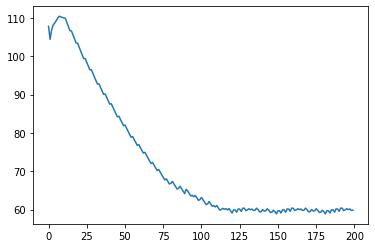

In [7]:
plt.plot(svm.loss)

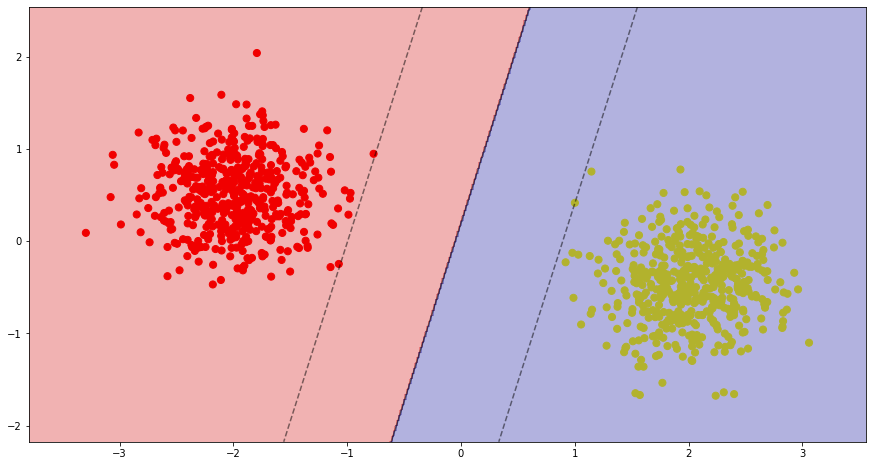

In [8]:
plot_class_border(X, y, svm)

In [9]:
svm.w

array([ 1.05835819, -0.27328741,  0.05428108])

### Приведение меток к {-1,1}

In [10]:
accuracy_score(y*2-1, svm.predict(X))

1.0

## Кейс 2: Линейно разделимые пересекающиеся классы

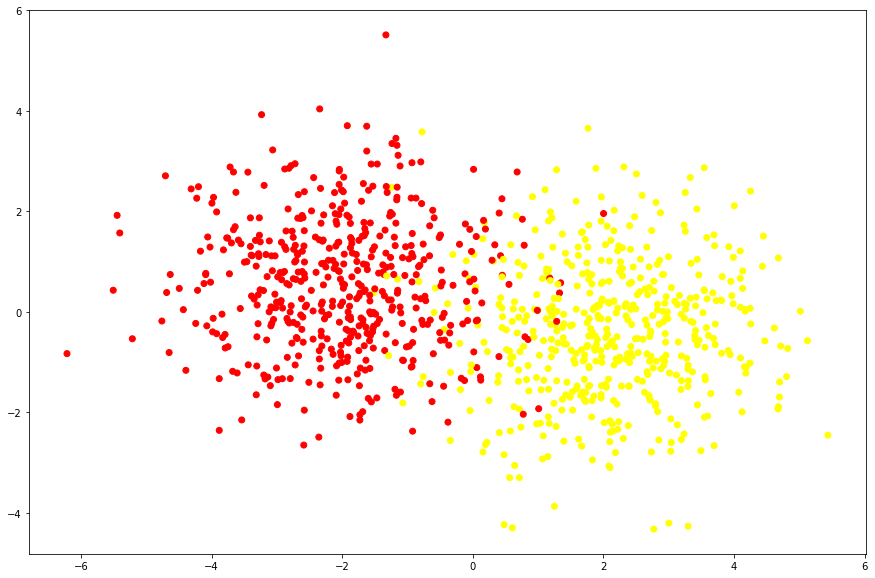

In [11]:
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[2,-0.5]], cluster_std=1.3, random_state=42)
plot_classification_set(X, y)

In [12]:
%%time
svm = LinearSVC()
svm.fit(X, y)

iter stoped on 54
CPU times: user 1.65 s, sys: 29.3 ms, total: 1.67 s
Wall time: 1.65 s


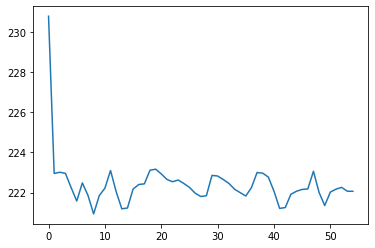

In [13]:
plt.plot(svm.loss)

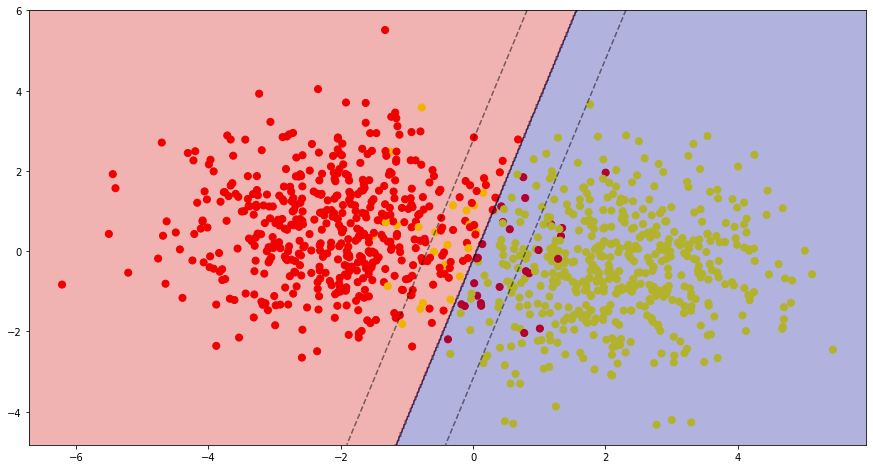

In [14]:
plot_class_border(X, y, svm)

## Кейс 3: Линейно неразделимые классы

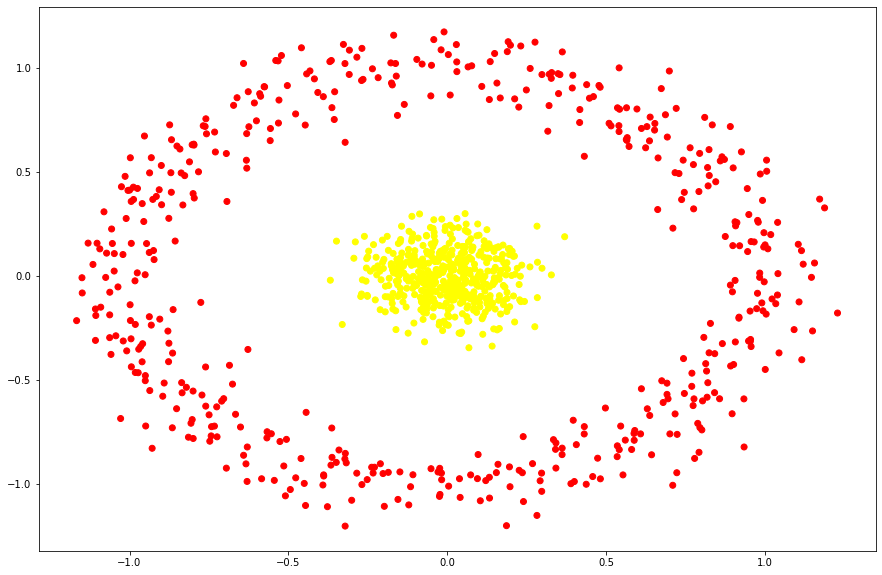

In [15]:
X, y = make_circles(1000, factor=.1, noise=.1)
plot_classification_set(X, y)

In [16]:
%%time
svm = LinearSVC()
svm.fit(X, y)

iter stoped on 37
CPU times: user 1.41 s, sys: 44.3 ms, total: 1.45 s
Wall time: 1.41 s


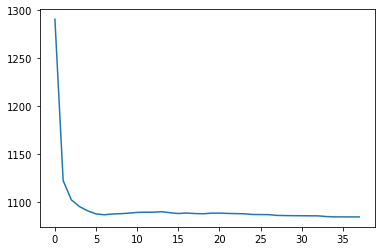

In [17]:
plt.plot(svm.loss)

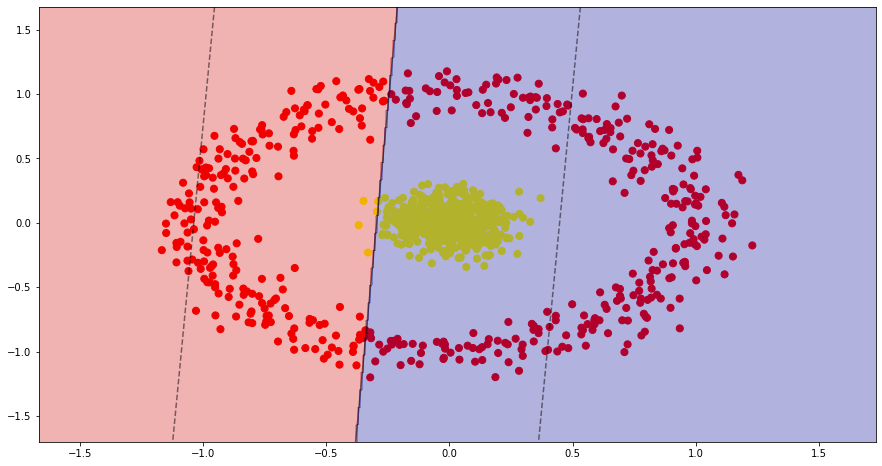

In [18]:
plot_class_border(X, y, svm)

# Реализация метода опорных векторов через ядра

Исходный код взят с ресурса: https://habr.com/ru/post/544282/

In [19]:
class Kernel:
    def __call__(self, a, b):
        raise NotImplementedError
    
class Linear(Kernel):
    def __call__(self, a, b):
        return np.dot(a, b.T)
    
class RBF(Kernel):
    def __call__(self, a, b):
        return np.exp(-np.sum((b - a[:, np.newaxis])**2, axis=-1))

In [20]:
a = Linear()
a(X, X).shape

(1000, 1000)

In [21]:
b = RBF()
b(X, X).shape

(1000, 1000)

In [22]:
class SVM:
    
    def __init__(self, kernel: str, C=0.1):
        if kernel == 'rbf':
            self.kernel = RBF()
        elif kernel == 'linear':
            self.kernel = Linear()
        else:
            raise ValueError('Kernel is not supported')
            
        self.C = C
        
    def restrict_to_square(self, t, v0, u):
        t = (np.clip(v0 + t * u, 0, self.C) - v0)[1] / u[1]
        return (np.clip(v0 + t * u, 0, self.C) - v0)[0] / u[0]
        
    def fit(self, X, y, max_iter=500):
        if not (np.abs(y) == 1).all():
            self.y = y * 2 - 1
        else:
            self.y = y
        n, m = X.shape
        self.X = X.copy()
        self.lambdas = np.zeros_like(self.y, dtype=float)
        self.K = self.kernel(self.X, self.X) * self.y[:, np.newaxis] * self.y
        
        for _ in range(max_iter):
            for idxM in range(n):
                idxL = np.random.randint(0, n)
                Q = self.K[[[idxM, idxM], [idxL, idxL]], [[idxM, idxL], [idxM, idxL]]]
                v0 = self.lambdas[[idxM, idxL]]
                k0 = 1 - np.sum(self.lambdas * self.K[[idxM, idxL]], axis=1)
                u = np.array([-self.y[idxL], self.y[idxM]])
                t_max = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15)
                self.lambdas[[idxM, idxL]] = v0 + u * self.restrict_to_square(t_max, v0, u)
                
            idx = np.nonzero(self.lambdas > 1E-15)
            self.b = np.mean((1 - np.sum(self.K[idx] * self.lambdas, axis=1)) * self.y[idx])
            
    def decision_function(self, X):
        return np.sum(self.kernel(X, self.X) * self.y * self.lambdas, axis=1) + self.b

    def predict(self, X):
        return (np.sign(self.decision_function(X)) + 1) // 2

## Кейс 1: Линейно разделимые непересекающиеся классы

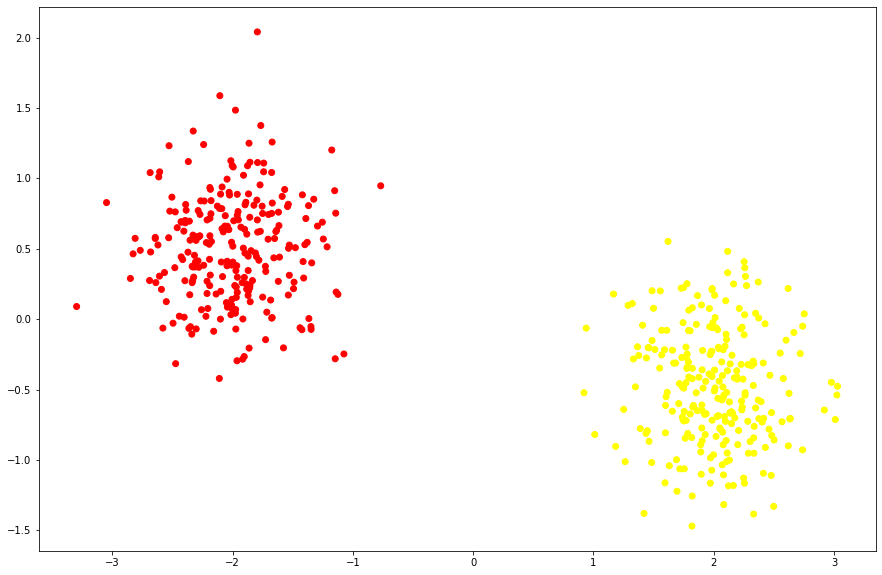

In [23]:
X, y = make_blobs(n_samples=500, centers=[[-2,0.5],[2,-0.5]], cluster_std=0.4, random_state=42)
plot_classification_set(X, y)

In [24]:
%%time
svm = SVM('linear')
svm.fit(X, y)

CPU times: user 34.7 s, sys: 452 ms, total: 35.1 s
Wall time: 34.6 s


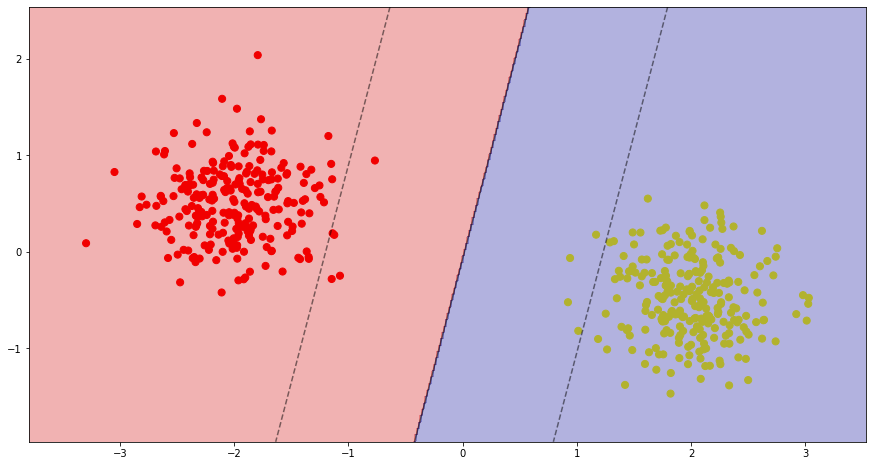

In [25]:
plot_class_border(X, y, svm)

## Кейс 2: Линейно разделимые пересекающиеся классы

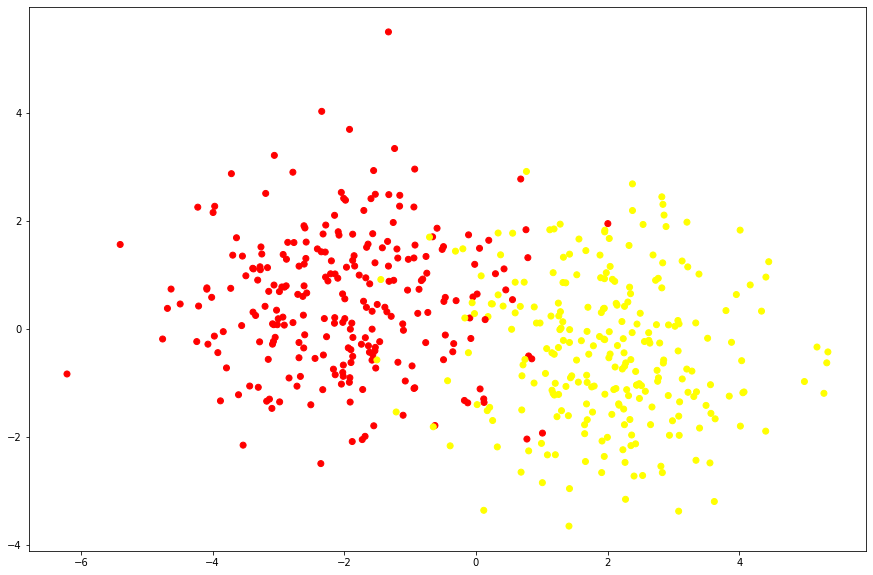

In [26]:
X, y = make_blobs(n_samples=500, centers=[[-2,0.5],[2,-0.5]], cluster_std=1.3, random_state=42)
plot_classification_set(X, y)

In [27]:
%%time
svm = SVM('linear')
svm.fit(X, y)

CPU times: user 30.9 s, sys: 439 ms, total: 31.3 s
Wall time: 30.8 s


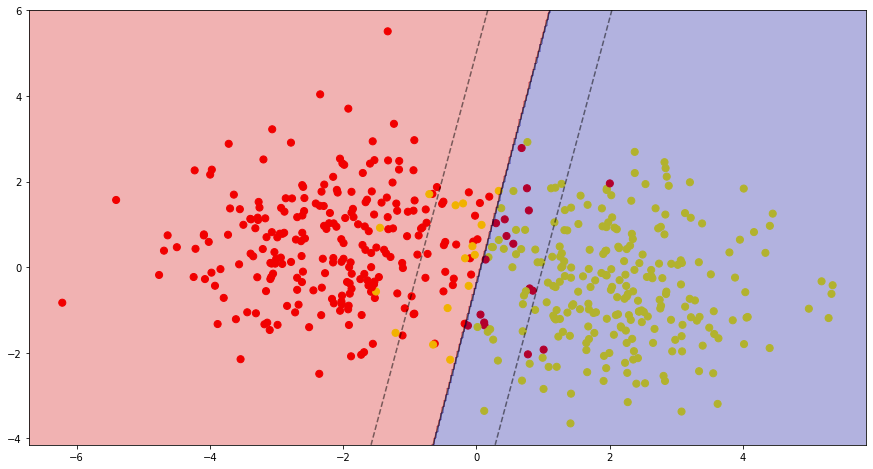

In [28]:
plot_class_border(X, y, svm)

## Кейс 3: Линейно неразделимые классы

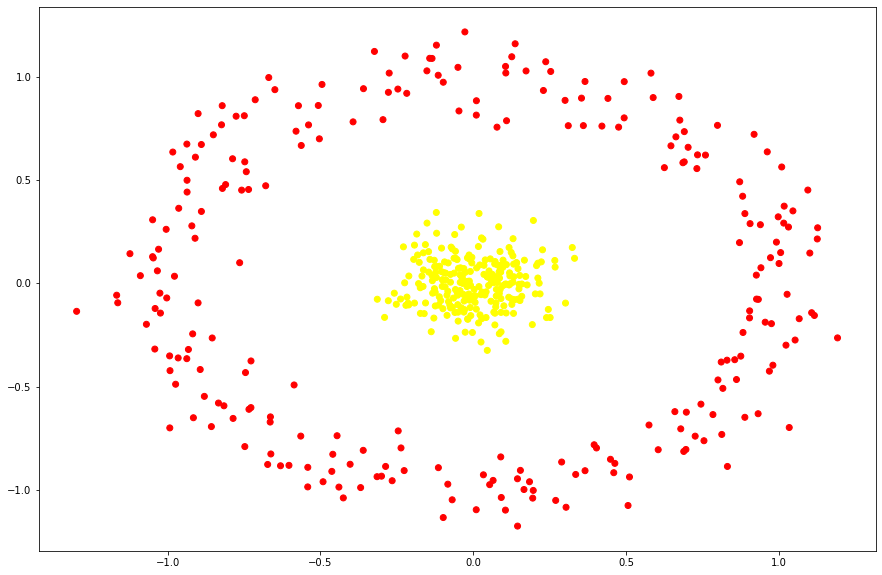

In [29]:
X, y = make_circles(500, factor=.1, noise=.1)
plot_classification_set(X, y)

In [30]:
%%time
svm = SVM('rbf')
svm.fit(X, y)

CPU times: user 39.4 s, sys: 8.16 ms, total: 39.4 s
Wall time: 39.4 s


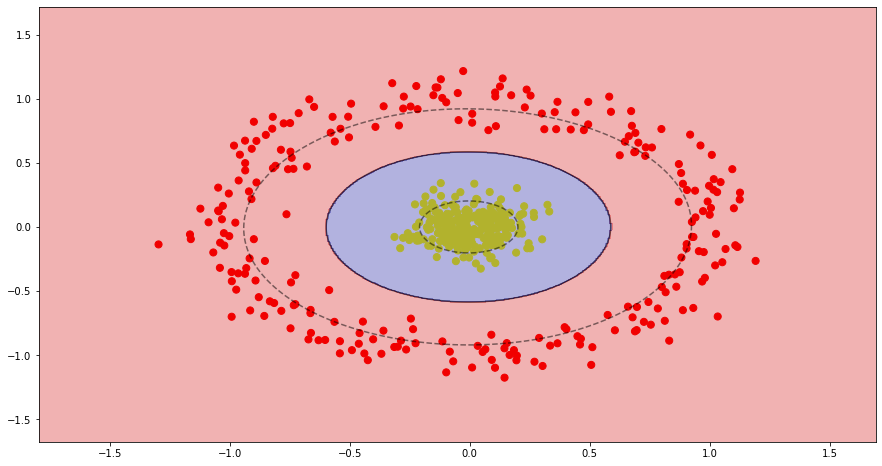

In [31]:
plot_class_border(X, y, svm)

### Два полумесяца

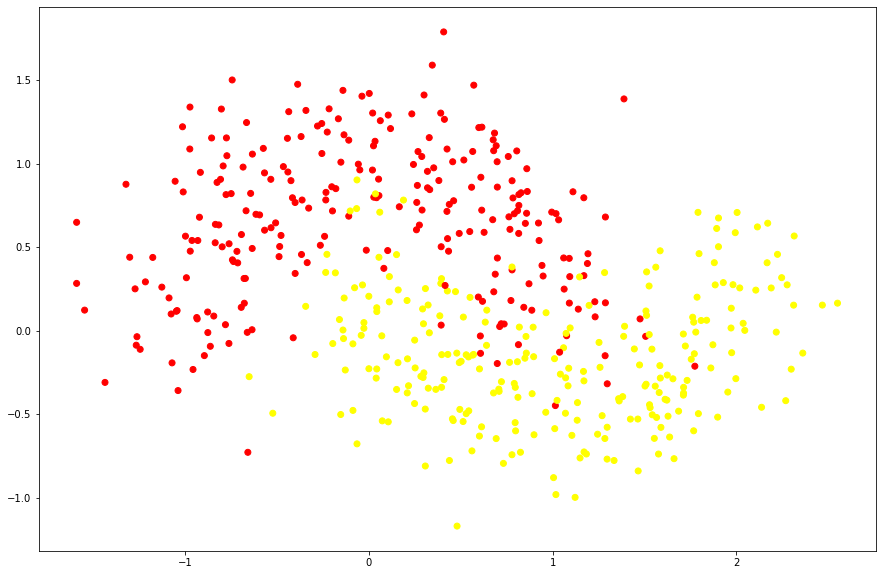

In [32]:
X, y = make_moons(500, noise=0.3)
plot_classification_set(X, y)

In [33]:
%%time
svm = SVM('rbf')
svm.fit(X, y)

CPU times: user 43.4 s, sys: 16.3 ms, total: 43.4 s
Wall time: 43.5 s


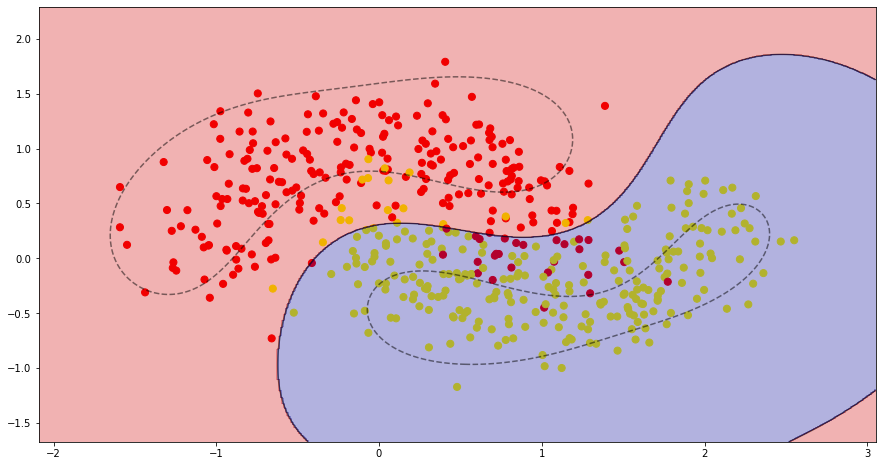

In [34]:
plot_class_border(X, y, svm)